In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [30]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

In [106]:
def slice_signals(signals_source, turbine_id, wind_bins = np.arange(4, 10.5, 0.5), temp_bins = [4, 15, 19, 24, 41]):
    indices = signals_source.loc[signals_source.Turbine_ID == turbine_id, :].index
    wind = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_WindSpeed_Avg, bins = np.arange(4, 10.5, 0.5))
    temp = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_Temp_Avg, bins = temp_bins)
    segments = pd.DataFrame({
        "Wind": wind, 
        "Temp": temp, 
        "Power": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Grd_Prod_Pwr_Avg, 
        "Time": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Timestamp_Datetime
    })
    return segments.dropna().loc[segments.Power >= 10, :].sort_values(by = ["Wind", "Temp", "Time"])

In [107]:
slice_signals(signals, "T01")

,Wind,Temp,Power,Time
4248,"(4.0, 4.5]","(4, 15]",83.2,2016-01-06 21:30:00
7702,"(4.0, 4.5]","(4, 15]",82.2,2016-01-11 16:40:00
8164,"(4.0, 4.5]","(4, 15]",117.6,2016-01-12 08:00:00
8183,"(4.0, 4.5]","(4, 15]",99.5,2016-01-12 08:40:00
8186,"(4.0, 4.5]","(4, 15]",144.7,2016-01-12 08:50:00
...,...,...,...,...
430612,"(9.5, 10.0]","(24, 41]",1356.4,2017-08-27 02:00:00
430648,"(9.5, 10.0]","(24, 41]",1358.5,2017-08-27 03:10:00
430666,"(9.5, 10.0]","(24, 41]",1351.4,2017-08-27 03:50:00
430864,"(9.5, 10.0]","(24, 41]",1435.6,2017-08-27 10:30:00


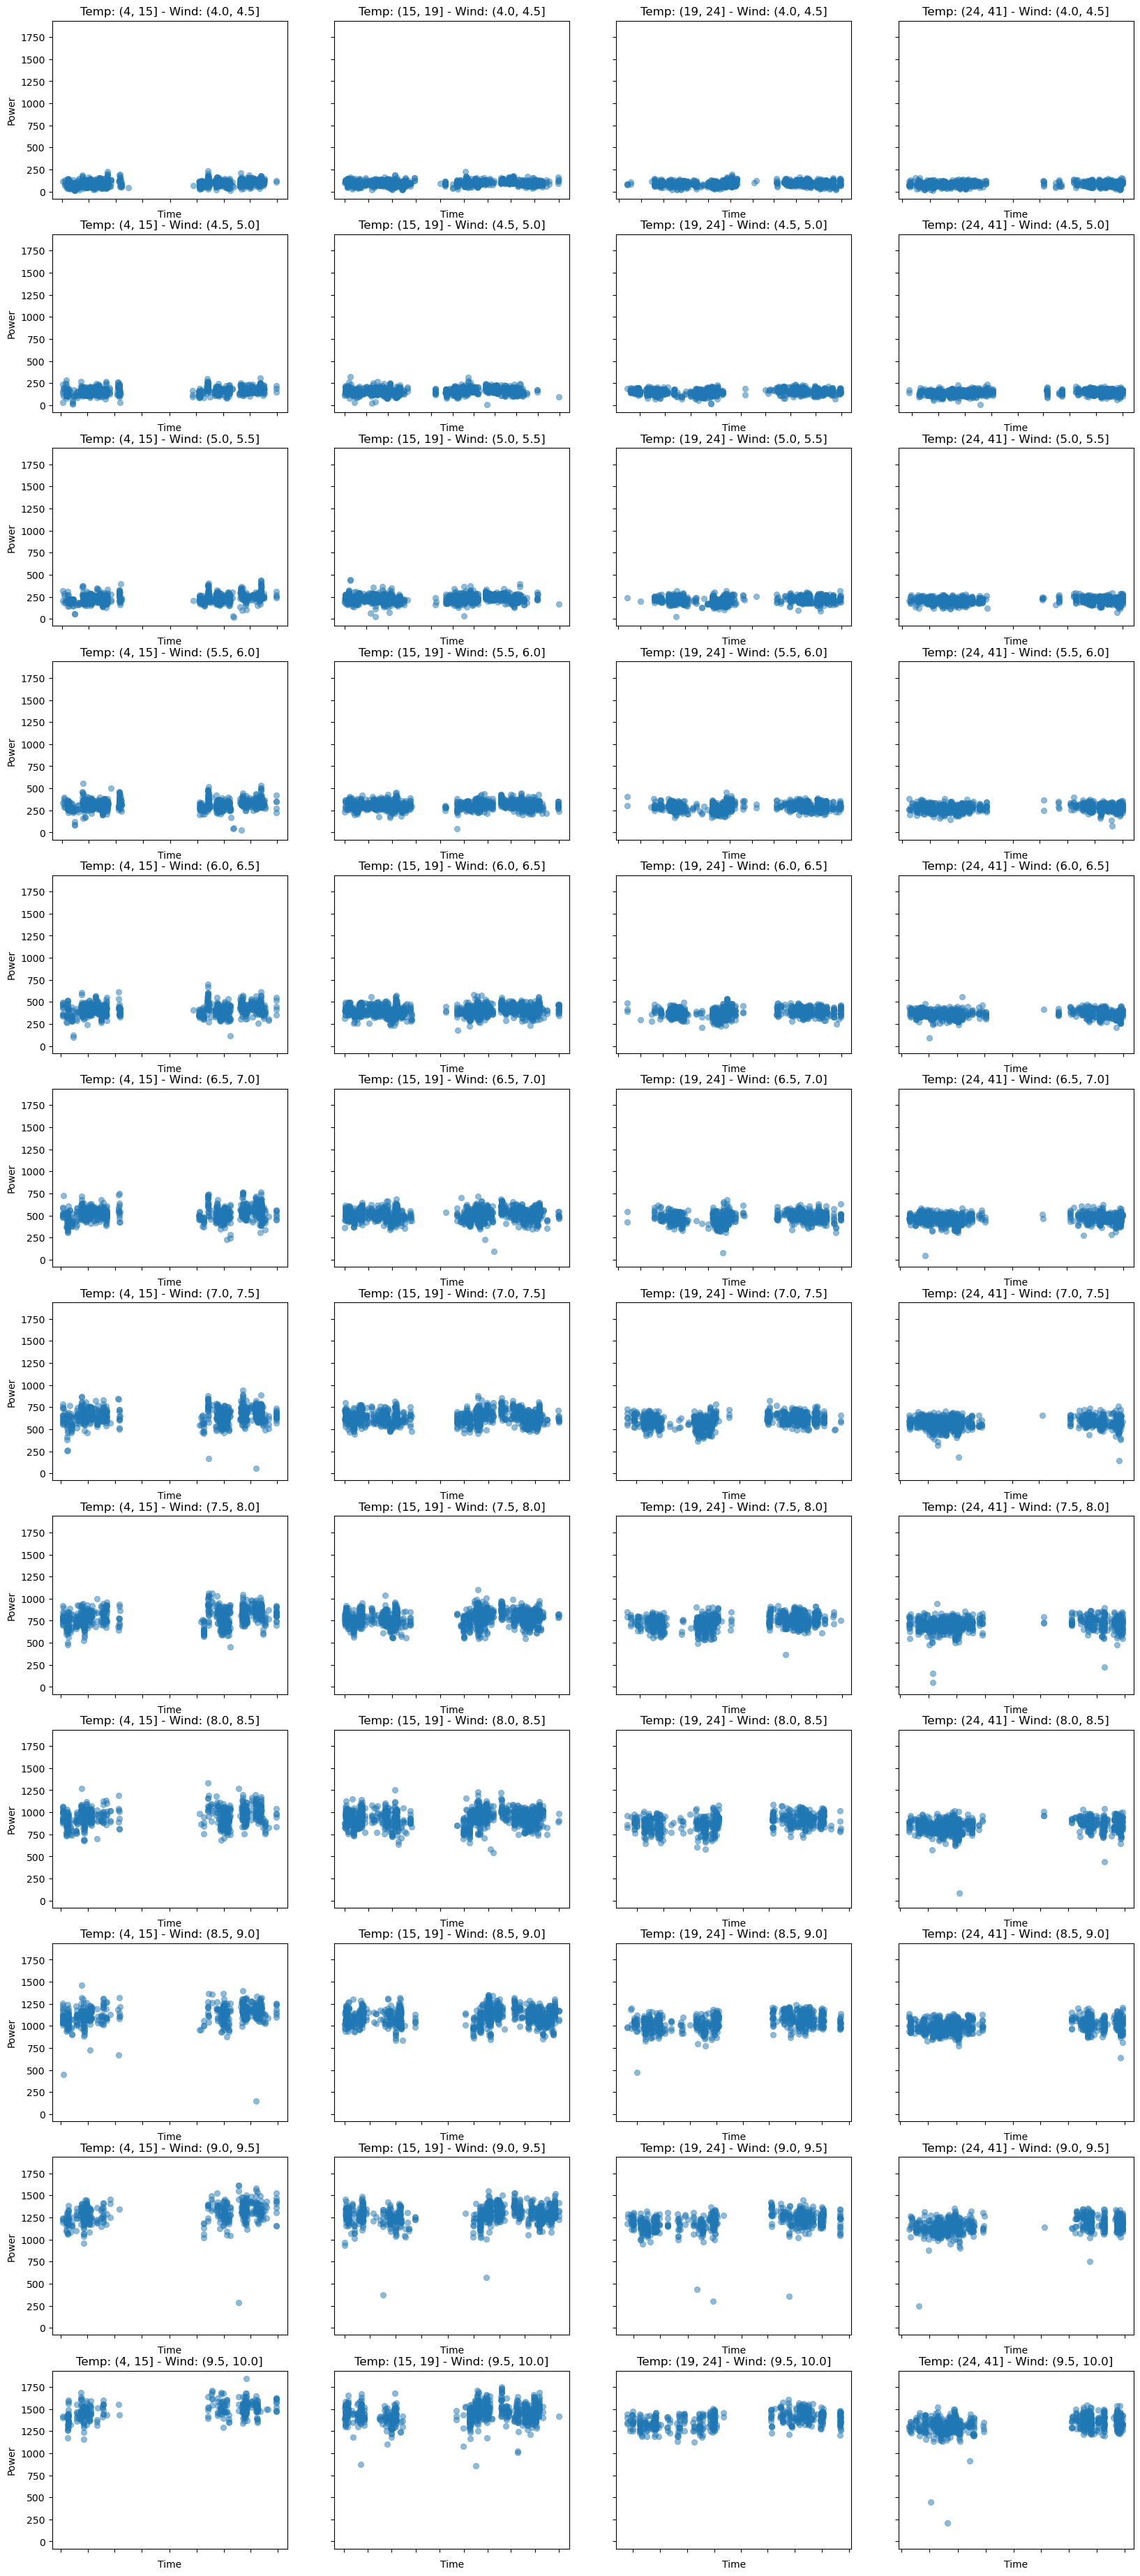

In [103]:
fig, axes = plt.subplots(12, 4, sharey = True, figsize = (20, 48))
for i, (name, group) in enumerate(slice_signals(signals, "T09").groupby(by = ["Temp", "Wind"])):
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], data = group, x = "Time", y = "Power", edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [121]:
for i, (name, group) in enumerate(slice_signals(signals, "T09").groupby(by = ["Temp", "Wind"])):
    

1046      10:50:00
4028      14:10:00
4072      15:40:00
4175      19:10:00
4233      21:00:00
            ...   
325664    22:20:00
325670    22:30:00
325675    22:40:00
346025    05:10:00
346029    05:20:00
Name: Time, Length: 1038, dtype: object
3525      21:30:00
3531      21:40:00
3539      21:50:00
3620      00:40:00
4014      13:40:00
            ...   
326566    04:20:00
326581    04:50:00
345363    07:10:00
345494    11:30:00
346044    05:50:00
Name: Time, Length: 851, dtype: object
1043      10:40:00
1077      11:50:00
3138      08:30:00
3591      23:40:00
3616      00:30:00
            ...   
325646    21:40:00
345446    09:50:00
345491    11:20:00
346035    05:30:00
346038    05:40:00
Name: Time, Length: 782, dtype: object
921       06:40:00
3141      08:40:00
3588      23:30:00
3599      23:50:00
3609      00:10:00
            ...   
345122    23:00:00
345195    01:30:00
345294    04:50:00
345368    07:20:00
345479    11:00:00
Name: Time, Length: 800, dtype: object
3133   